First we should import some packages that we will use.

In [2]:
from obspy.core import Stream, UTCDateTime
from obspy.clients.fdsn import Client

Our client is used to make web requests from a data center.  Here is a list of other data centers: [link](https://www.fdsn.org/datacenters/)

In [9]:
client=Client('IRIS')

Now lets take a look at the M7.6 that was near Japan earlier this year.

In [10]:
stime = UTCDateTime('2024-001T07:10.00')
etime = stime + 4*60*60

Another option if you want event information as well is to use get_events.

In [15]:
cat = client.get_events(starttime=stime, endtime=etime, minmagnitude=7)
print(cat[0].origins[0])
print(cat[0].magnitudes[0])

Origin
	   resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=49462969")
	          time: UTCDateTime(2024, 1, 1, 7, 10, 9, 474000)
	     longitude: 137.2638
	      latitude: 37.4893
	         depth: 10000.0
	 creation_info: CreationInfo(author='pt,at,us')
Magnitude
	    resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?magnitudeid=214721095")
	            mag: 7.5
	 magnitude_type: 'mww'
	  creation_info: CreationInfo(author='us')


We can take a look at what this event looks like at various places by grabbing some stations and their metadata.

In [18]:
inv = client.get_stations(network='IU', starttime=stime, endtime=etime)
print(inv)

Inventory created at 2024-02-05T19:53:55.819200Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2024-01-01...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			IU
		Stations (77):
			IU.ADK (Adak, Aleutian Islands, Alaska)
			IU.AFI (Afiamalu, Samoa)
			IU.ANMO (Albuquerque, New Mexico, USA)
			IU.ANTO (Ankara, Turkey)
			IU.BBSR (Bermuda Institute of Ocean Sciences, St George's Bermuda)
			IU.BILL (Bilibino, Russia)
			IU.CASY (Casey, Antarctica)
			IU.CCM (Cathedral Cave, Missouri, USA)
			IU.CHTO (Chiang Mai, Thailand)
			IU.COLA (College Outpost, Alaska, USA)
			IU.COR (Corvallis, Oregon, USA)
			IU.CTAO (Charters Towers, Australia)
			IU.DAV (Davao, Philippines)
			IU.DWPF (Disney Wilderness Preserve, Florida, USA)
			IU.FUNA (Funafuti, Tuvalu)
			IU.FURI (Mt. Furi, Ethiopia)
			IU.GNI (Garni, Armenia)
			IU.GRFO (Grafenberg, Germany)
			IU.GUMO (Guam, Mariana Islands)
			IU.HKT (

So now lets pick a couple of stations and get their data.  I am going to pick MAJO and ANMO.  We can find out more about the metadata of these stations using the EarthScope MDA: [link](http://ds.iris.edu/mda/)

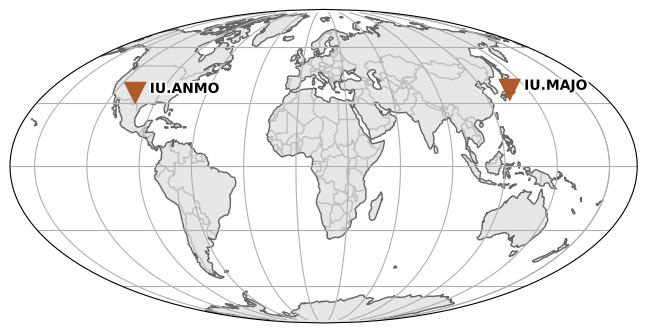

In [38]:
inv.plot();

In [ ]:
net, sta, loc, chan = 'IU', 'MAJO,ANMO','00', 'LHZ'

inv = client.get_stations(network=net, starttime=stime, 
                          endtime=etime, station=sta, 
                          level='response', channel=chan)
print(inv)


The SNCL, which should really be called NSCL.

Network: A two letter code that defines a collection of station (e.g., IU)

Station: A three to five letter code that defines the station (e.g., MAJO and ANMO)

Location Code: A two letter code that defines the particular sensor (e.g., 00, 10, 60).  This is sometimes left blank.

Channel: A three letter code that defines the sampling rate (e.g., L), the band (e.g., H for high-gain), and the direction of sensitivity (e.g., Z for vertical).



Now lets get some data and plot it up.

In [29]:
st = client.get_waveforms(net, sta, loc, chan, stime, etime)
print(st)

2 Trace(s) in Stream:
IU.ANMO.00.LHZ | 2024-01-01T07:10:00.069538Z - 2024-01-01T11:09:59.069538Z | 1.0 Hz, 14400 samples
IU.MAJO.00.LHZ | 2024-01-01T07:10:00.069538Z - 2024-01-01T11:09:59.069538Z | 1.0 Hz, 14400 samples


Now lets plot some of this data.

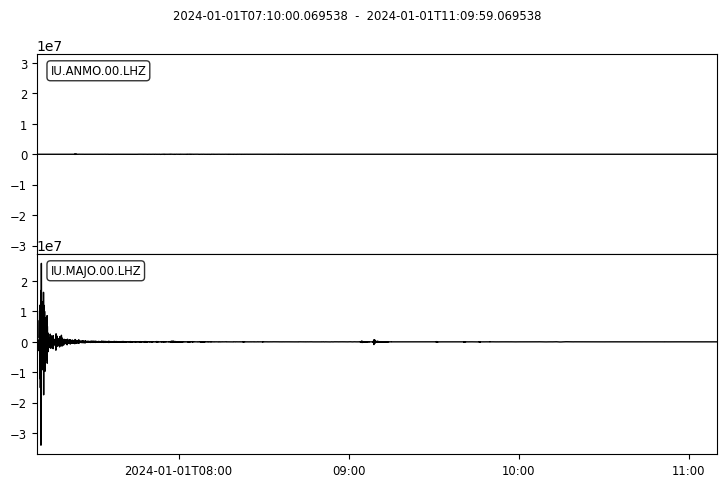

In [37]:
st.plot();

What are the units of these data and why is ANMO showing nothing but MAJO shows the earthquake?

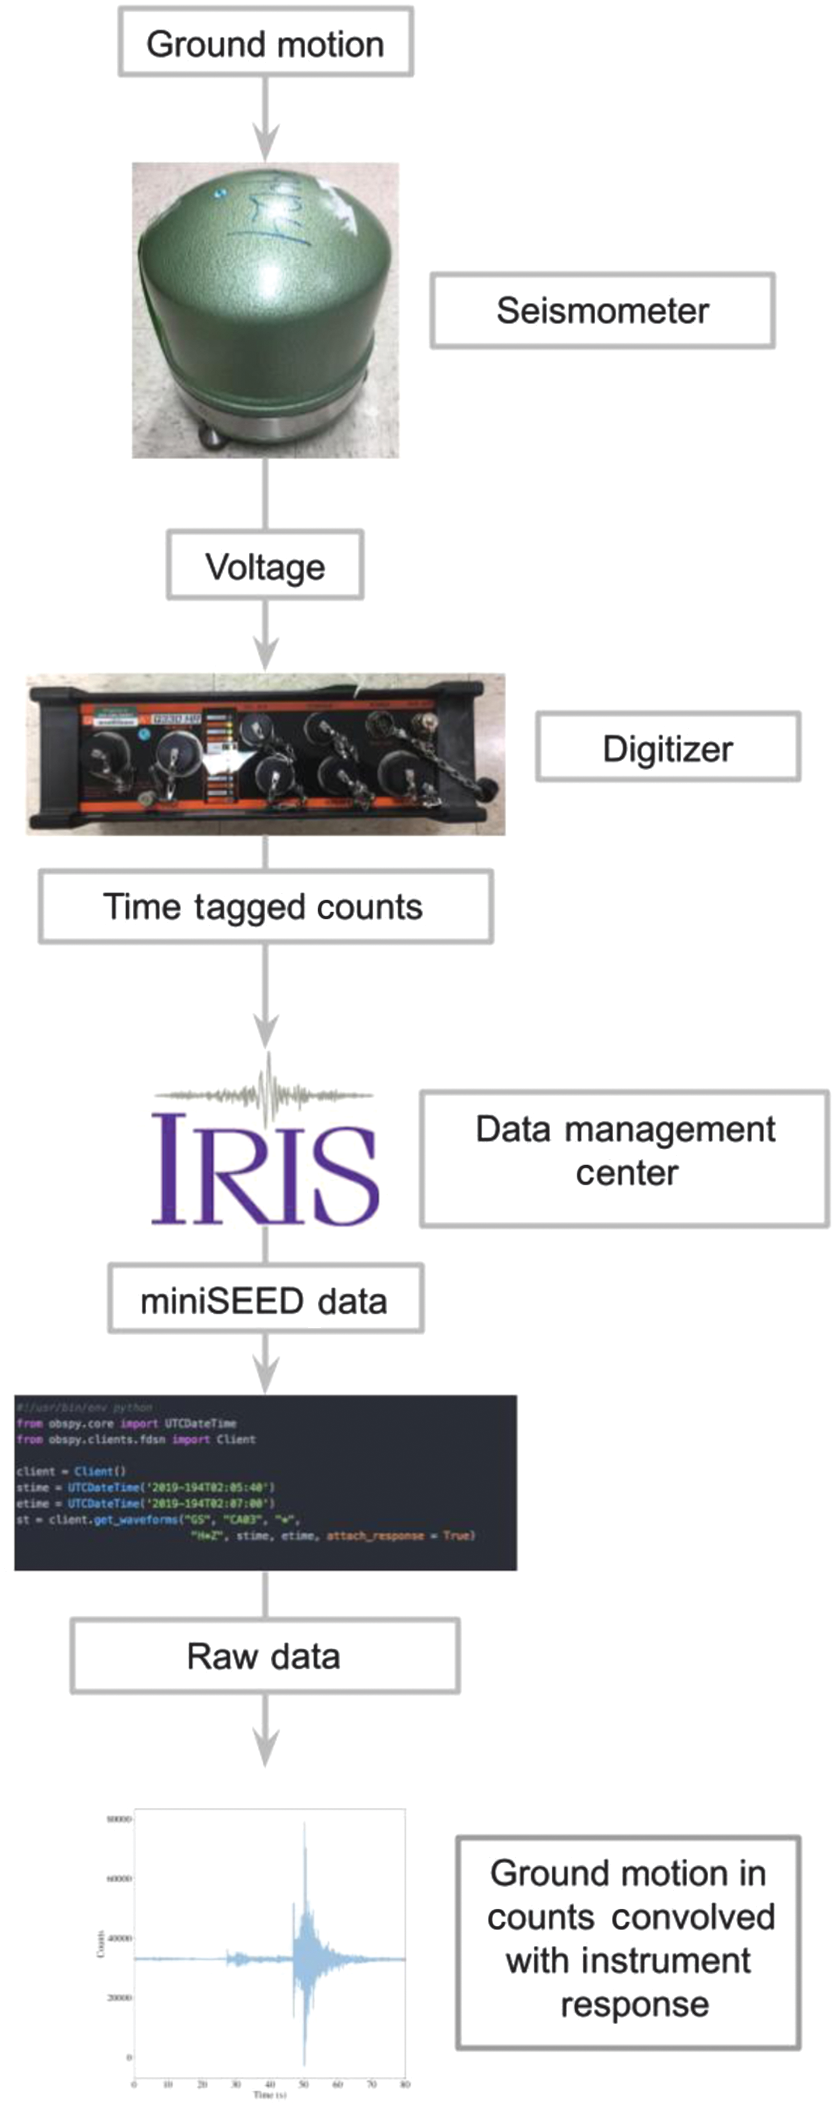

We need to discuss the instrument response and how to remove it.

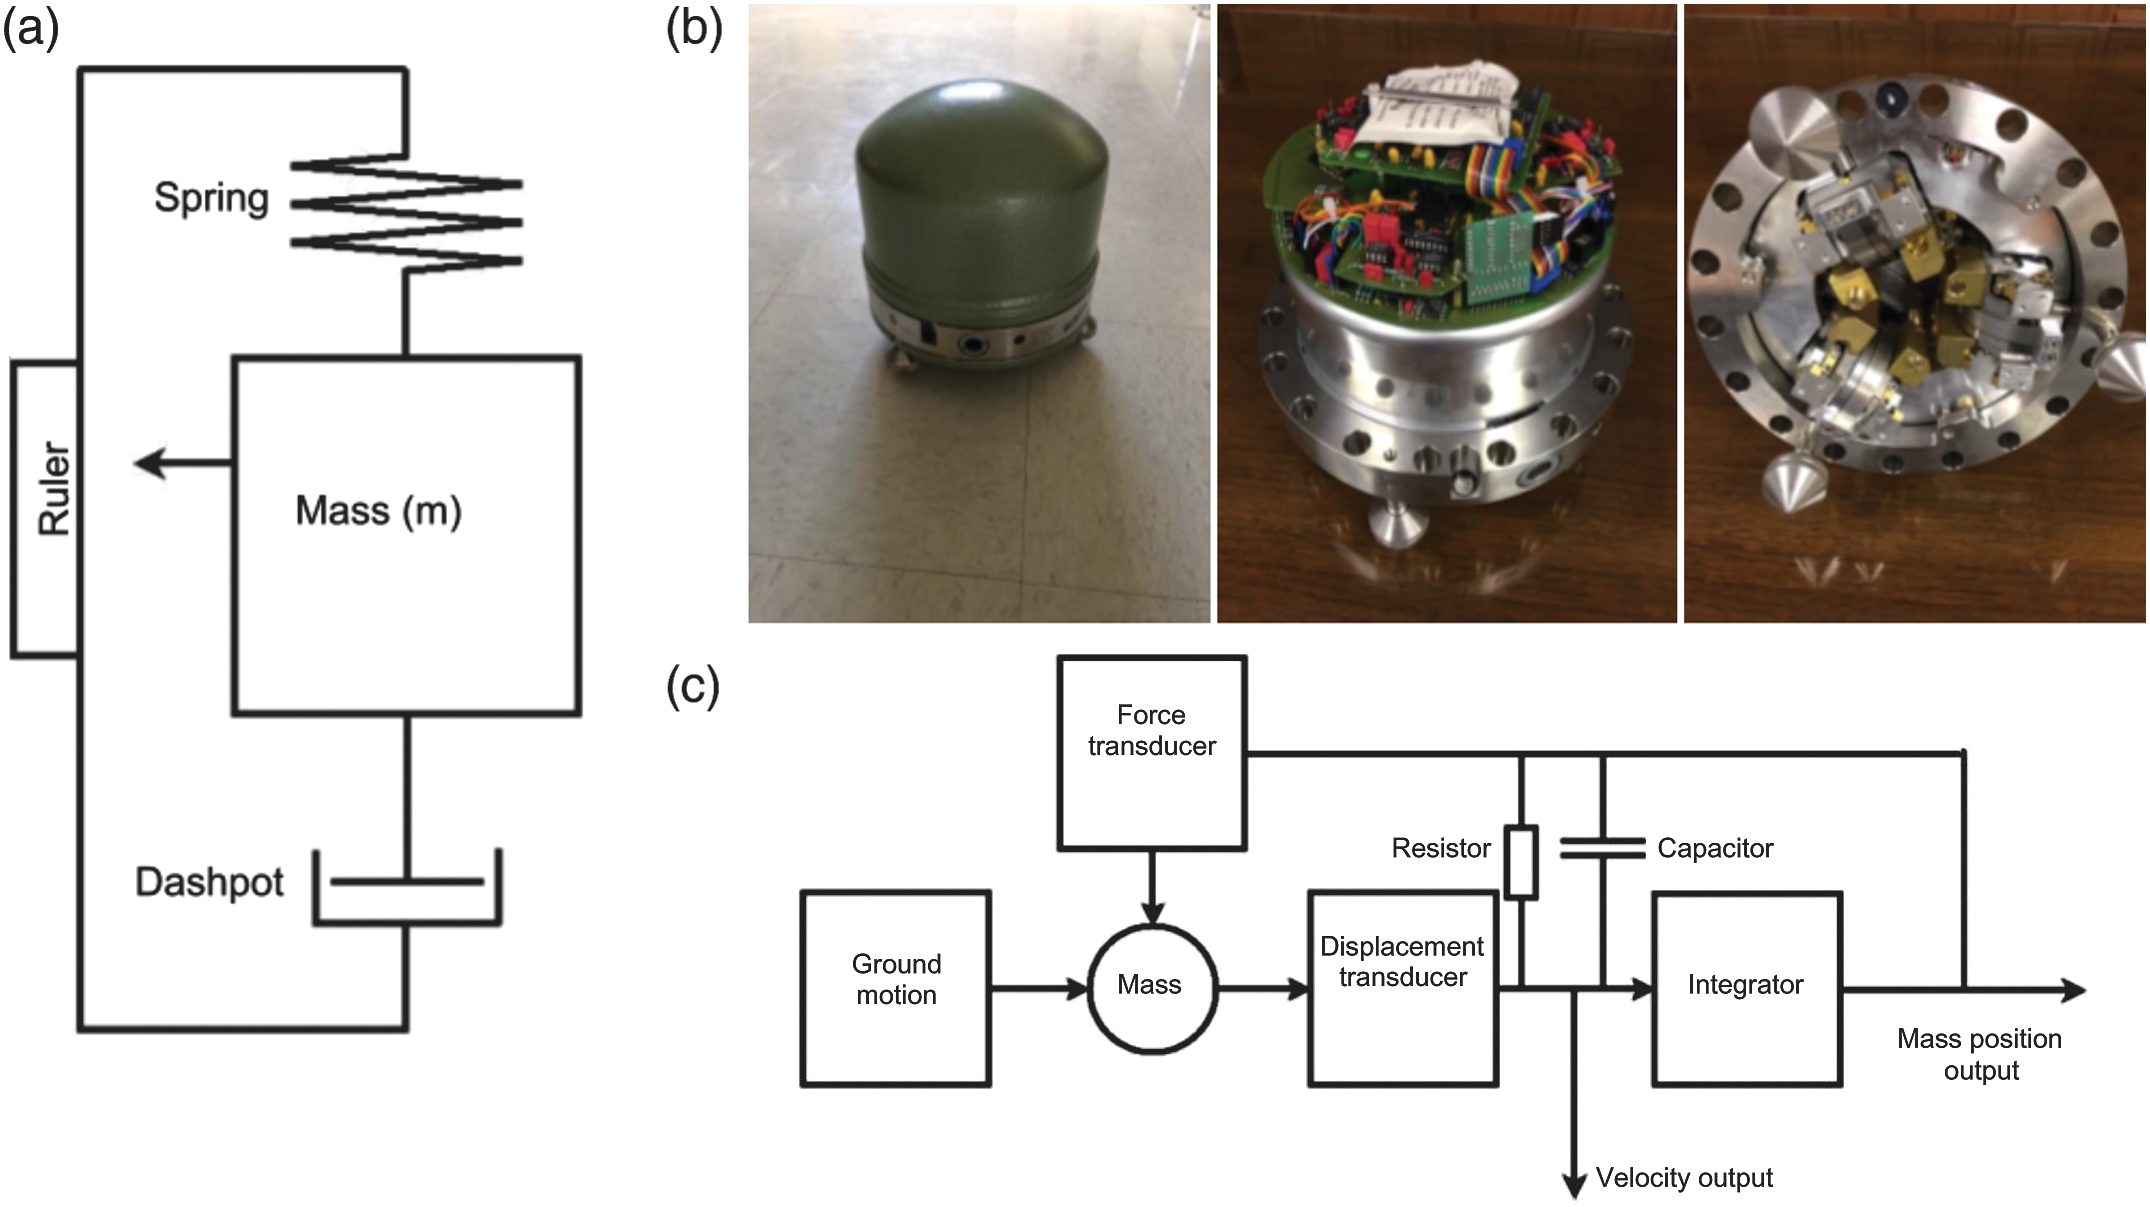

In the most simple example we can view a seismometer as recording the movement of the ruler relative to the mass.  So we need to account for the dashpot and the spring.  The right side shows a more typical example using a feedback system.

In [33]:
print(inv[0][0][0].response)

Channel Response
	From m/s (Velocity in Meters Per Second) to counts (Digital Counts)
	Overall Sensitivity: 1.97536e+09 defined at 0.020 Hz
	3 stages:
		Stage 1: PolesZerosResponseStage from m/s to V, gain: 1183
		Stage 2: CoefficientsTypeResponseStage from V to counts, gain: 1.67772e+06
		Stage 3: CoefficientsTypeResponseStage from counts to counts, gain: 1


Going back to our figure, that shows the steps in data processing, above we can see that the response allows us to convert from digital counts (what our data is in) to meters per second (velocity).  This response has three stages.

Stage 1: Analog stage (seismometer)

Stage 2: Digital stage (digitizer)

Stage 3: Decimation stage (lowers the sample rate of the data).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


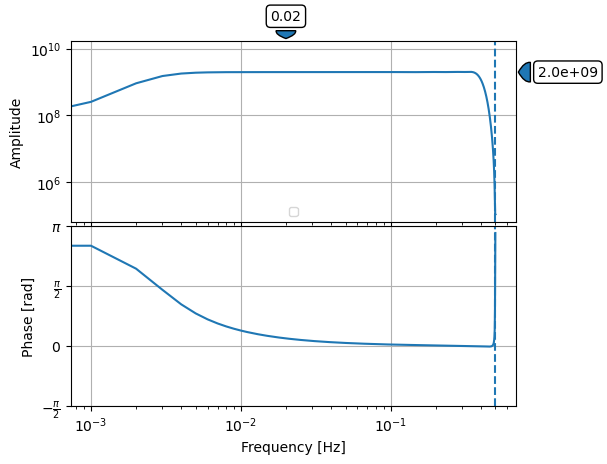

In [36]:
inv[0][0][0].response.plot(min_freq=0.001);

Top is the amplitude response and bottom is the phase response.  As you can see the top rolls off at high-frequency and at low-frequency and is "flat to velocity" from 360 s to about 2 s.

If you look back up at the response information you can see that the counts to m/s is 

Overall Sensitivity: 1.97536e+09

In [39]:
st.remove_response(inventory=inv)

2 Trace(s) in Stream:
IU.ANMO.00.LHZ | 2024-01-01T07:10:00.069538Z - 2024-01-01T11:09:59.069538Z | 1.0 Hz, 14400 samples
IU.MAJO.00.LHZ | 2024-01-01T07:10:00.069538Z - 2024-01-01T11:09:59.069538Z | 1.0 Hz, 14400 samples

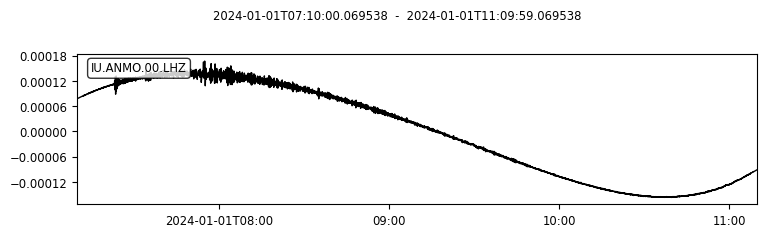

In [41]:
st[0].plot();

What is going on with the odd drift?

In [50]:
st.taper(0.05)
st.filter('highpass',freq=0.01)


2 Trace(s) in Stream:
IU.ANMO.00.LHZ | 2024-01-01T07:10:00.069538Z - 2024-01-01T11:09:59.069538Z | 1.0 Hz, 14400 samples
IU.MAJO.00.LHZ | 2024-01-01T07:10:00.069538Z - 2024-01-01T11:09:59.069538Z | 1.0 Hz, 14400 samples

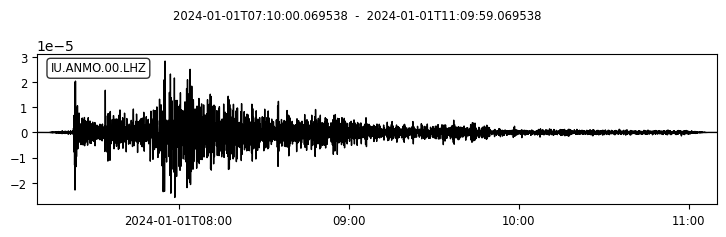

In [51]:
st[0].plot();

Now that looks better!  What are the units now?

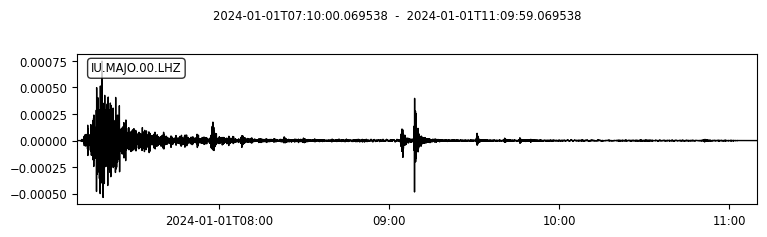

In [52]:
st[1].plot();

In [55]:
st[1].trim(stime, stime+20*60)

IU.MAJO.00.LHZ | 2024-01-01T07:10:00.069538Z - 2024-01-01T07:30:00.069538Z | 1.0 Hz, 1201 samples

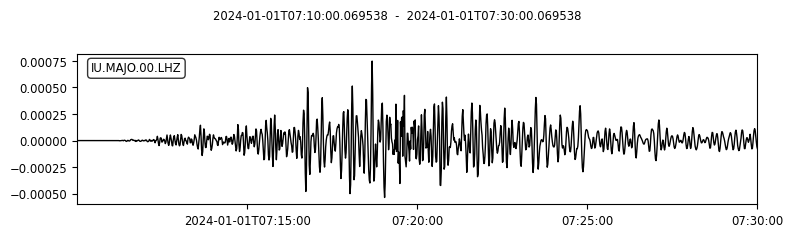

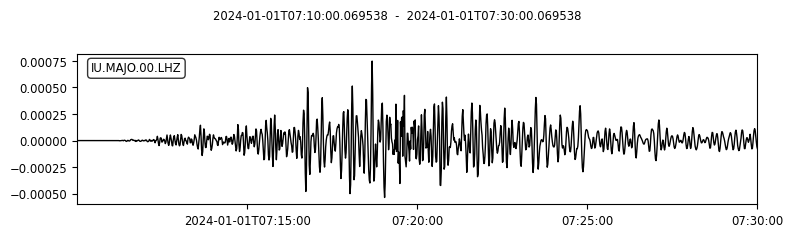

Add Rotation pieces: https://service.iris.edu/irisws/rotation/docs/1/help/

Add strong motion versus weak motion

Add the velocity/displacement/acceleration

